In [1]:
import pandas as pd
from collections import defaultdict
import json
import krippendorff
import numpy as np
from scipy import stats
import seaborn as sns
import string
import re
import collections
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
import random
import matplotlib.pyplot as plt
import matplotlib.colors
#import plotly.express as px
#import geopandas
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm
import os
import statistics

In [2]:
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    se = results.bse
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"p value":pvals,
                               "coeff":coeff,
                               "SE":se,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df.reset_index()
    results_df['term'] = results_df['index']
    return results_df

def add_star(p):
    sig = ' '
    if p < 0.05:
        sig = '*'
    else:
        sig = ' '
    if p < 0.01:
        sig = '**'
    if p < 0.001:
        sig = '***'
   
    return sig

        
def plot_reg_results(df, nrows = 1, ncols = 1, figsize=(4, 2), xlabel='xlabel', labels = None, title='', filename=None):
    #df = df.sort_values('coeff')
    xs = df['coeff']
    norm = matplotlib.colors.Normalize(vmin=min(xs)*2, vmax=max(xs)*2)
    mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
    colors = np.array([(mapper.to_rgba(v)) for v in xs])
    en_len = int(len(df))
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes=[axes] if nrows + ncols <= 2 else axes
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.6)
    #plt.title('Uncertainty in Fields')
    st = fig.suptitle("", fontsize=14)
    #sigg = fig.suptitle("Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1", fontsize=14)
    for i in range(len(axes)):
        ax = axes[i]
        ax.set_ylim(-0.7, len(df['term'][:en_len])-0.2)
        ax.axvline(x=0.00,color='black',linewidth=1.7,linestyle='-')
        ax.xaxis.grid(True)
        ax.yaxis.label.set_color('white')
        #ax.set_xticks([-0.5, 0.0, 0.5, 1,0])
        #ax.set_xlabel(r"%s ($\beta$ coef.)"%xlabel, fontsize=14)
        ax.set_xlabel(xlabel,fontsize=14)
        #ax.set_xticks([-0.04, -0.02, 0, 0.02, 0.04])
        #ax.set_title(r"%s"%(labels[i] if labels else dvs[i]), fontsize=14)
        s = en_len*i
        en = en_len*(i+1)
        for x, y, e, p, color in zip(df['coeff'][s:en], df['term'][s:en], df['SE'][s:en],df['p value'][s:en], colors[s:en]):
            #plt.plot(x, y, 'o', color=color)
            ax.errorbar(x=[x], y=[y], xerr=[e], color=color,fmt='o')
            sig = ' '
            if p < 0.05:
                sig = '*'
            if p < 0.01:
                sig = '**'
            if p < 0.001:
                sig = '***'
            ax.annotate(sig, # this is the text
                     (x+0.00001,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-0.5), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

        #ax.set_xticklabels([-0.04, -0.02, 0, 0.02, 0.04], fontsize=14)
        ax.set_yticklabels(list(df['term']), fontsize=14)

    #fig.text(0.5, 0.04, 'common X', ha='center')
    st.set_y(-0.02)
    #sigg.set_y(-0.12)
    fig.text(0.5, -0.17, s="%s"%title,ha='center',fontsize=14)
    fig.text(0.5, -0.18, s="Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05",ha='center',fontsize=9)
    if filename:
        plt.savefig('../figures/%s.pdf'%filename, bbox_inches='tight')

In [3]:
s2s = {
    'The science news story sounds interesting to me': 'News story is interesting to me',
    'Understanding the science news story requires specialized knowledge': 'Needs specialized knowledge',
    'The science news story is fun to read': 'News story is fun to read',
    'The science news story should be published in the news': 'Should be published in news',
    'The science news story tackles an important issue': 'Tackles an important issue',
    'I can understand the science news story': 'I understand the news story',
    'The science news story could be interesting to the general public': 'Could interest the general public',
    'The scientific finding seems surprising to me': 'Finding is surprising to me',
    'The scientific finding could be controversial': 'Finding could be controversial',
    'Knowing about this science could benefit a lot of people': 'Could benefit many people',
    'This science news story is overstated or exaggerated': 'News story is exaggerated',
    'I learned something useful from the science news story': 'I learned something useful',
    'I would share this science news story with someone I know directly': 'Would share directly',
    'I would share this science news story with a wider forum like a mailing list, twitter, reddit': 'Would share on wider forum',
    'I would be unlikely to share this science news story with anyone': 'Unlikely to share',
    'Policy makers': 'Policy makers',
    'A segment of the public': 'A public segment',
    'Companies in the related industries': 'Related industry companies',
    'The general public': 'General public',
    'Other popular media (e.g. TV and radio)': 'Other popular media',
    'Other popular print media (e.g. Vogue, GQ, Elle, People, Time and Reader’s Digest)': 'Popular print media',
    'Science and Technology media (e.g. Scientific American, National Geographic)': 'Sci-Tech media',
    'My normal feed/content/timeline on a social media site (e.g. Facebook, Instagram and Twitter)': 'My social media feed',
    'General news outlets (e.g. BBC, New York Times, Fox News)': 'General news outlets',
    'It should not be published in public media outside the science community': 'Shouldn\'t be public outside science'
}

def load_info_dict(path='surveyflow', files = ['demographic_information','experience_with_science','political_orientation']):
    info_dict = {}
    question_dict = {}
    for f in files:
        info_dict[f] = {}
        t_df = pd.read_json(os.path.join(path, f) + '.jsonl', orient='records', lines=True)
        for i,row in t_df.iterrows():
            info_dict[f][row['text']] = dict(row)
            question_dict[row['text']] = dict(row)
            question_dict[row['text']]['category'] = f
    return info_dict, question_dict

labels = ['Strongly Disagree', 'Disagree', 'Neutral', 'Agree' , 'Strongly Agree']
label2score = {l:i for i,l in enumerate(labels)}
info_dict, question_dict = load_info_dict()
def convert_data(df, multirate_keys = ['Readability and newsworthiness', 'Practical implications and controversy', 'Sharing','benefit','publishing']):
    return_dict = defaultdict(list)
    cols = list(df.columns)
    for i, row in df.iterrows():
        item = {}
        for key_label in cols:
            key = key_label.split(":::")
            if len(key) == 1:
                item[key[0]] = row[key_label]
            elif key[0] == 'span_annotation':
                item[key[0]] = eval(row[key_label])
            elif key[1]=='bad_text':
                item['bad_text'] = row[key_label]
            elif len(key) == 2:
                #print(key_label, row[key_label])
                if key[0] in multirate_keys:
                    if str(row[key_label]) == 'nan':
                        item[key_label] = np.nan
                    else:
                        item[key_label] = label2score[row[key_label]]
                elif key[0] in question_dict:
                    if question_dict[key[0]]['schema'] == 'radio':
                        if key[0] not in item:
                            item[key[0]] = np.nan
                        if str(row[key_label]) != 'nan':
                            item[key[0]] = key[1]
                    elif question_dict[key[0]]['schema'] == 'multiselect':
                        if key[0] not in item:
                            item[key[0]] = []
                        if str(row[key_label]) != 'nan':
                            item[key[0]].append(key[1])
                    
                else:
                    #print(str(row[key_label]))
                    if key[0] not in item:
                        item[key[0]] = None

                    elif str(row[key_label]) != 'nan':
                        item[key[0]] = row[key_label]
                
                #if key[0] not in item:
                #    item[key[0]] = None
                #if row[key_label] == True:
                #    if key[1][:5] == 'scale':
                #        item[key[0]] = int(key[1].split('_')[1])
                #    else:
                #        item[key[0]] = key[1]
            else:
                print('error key: ', key)
        for key in item:
            return_dict[key].append(item[key])
    for key in return_dict:
        print(key,len(return_dict))
    return pd.DataFrame(return_dict)

question2key = {
    "What is your gender?": "gender",
    "What is your age?": "age",
    "How do you describe your race or ethnicity (You may select more than one option)": "race",
    "What is your education level?": "education",
    'How frequently do you read science news?': "science_news_consumption",
   'Which of the following, if any, do you regularly get your science news from (Select all that apply)?': "get_news_from_outlets",
   'Which, if any, of these science-related topics are you interested in?':'topic_of_interests',
   'In general, how much would you say that you trust science?':"trust_in_science",
   'In general, how much do you trust scientists to find out accurate information about the world?':"trust_in_scientist_ability",
   'How much do you trust scientists to do their work with the intention of benefiting the public?':"trust_in_scientist_intentin",
   'How much do you know about what scientists do?':"knowledge_about_scientists",
   'How satisfied do you feel about your experience participating our study?':"study_experience",
   'How do you feel about your experience participating our study compared with other studies?':"study_experience_comparison",
   'If you choose Asian above, please specify (please choose Not Applicable if you are not Asian)':"Asian_details",
   'What is your employment status?': "employment"
}

q2q = {
    'Please rate the following statements: Individuals should have the right to define their own gender identity and marry whomever they choose.': 'Right to self-define gender & choose marital partner.',
    'Please rate the following statements: Drugs, especially softer ones like marijuana, should be decriminalized or legalized.': 'Decriminalization/legalization of drugs, especially marijuana.',
    'Please rate the following statements: The government should actively intervene in the market to ensure equality and consumer protection.': 'Government intervention for market equality & consumer protection.',
    'Please rate the following statements: Wealthy individuals and corporations should pay a higher tax rate to fund public services.': 'Higher tax for wealthy & corporations to fund public services.',
    'Please rate the following statements: Women should have the complete right to make decisions about their reproductive health, including access to abortion.': "Women's full rights on reproductive health & abortion access.",
    'Please rate the following statements: Government should invest heavily in public services like healthcare, education, and welfare.': 'Heavy government investment in healthcare, education, & welfare.'
}

def get_user_dict(ann_df):
    user_keys = set(ann_df['user'])
    user_dict = defaultdict(dict)
    for key in info_dict:
        df = ann_df[ann_df.instance_id.str.contains(key)]
        for i, row in df.iterrows():
            for k in info_dict[key]:
                user_dict[row['user']][k] = row[k]#.split(':::')[-1] if type(v)==str else v
    return user_dict

def attach_user_info(ann_df, user_dict, keys):
    for key in keys:
        ann_df[key] = [user_dict[user][key] if key in user_dict[user] else None for user in ann_df['user']]
    return ann_df

def edit_distance(str1, str2):
    # Create a table to store the edit distances for substrings
    m = len(str1)
    n = len(str2)
    dp = [[0 for _ in range(n + 1)] for _ in range(m + 1)]

    # Initialize the table
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    # Compute the edit distances for substrings
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if str1[i - 1] == str2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1]) + 1

    # The edit distance between the two strings is stored in the bottom-right cell
    return dp[m][n]
def get_mean(s):
    '''
        Return the mean of a list of labels
        Input: a list of labels (can contain 'bad_text' or 'nan')
        Output: a float or None
    '''
    s = [int(it) for it in s if it!='bad_text' and str(it) != 'nan']
    return sum(s)/len(s) if len(s) > 0 else None

def split_half_corr(df, key='pure_scores', seeds = [0,1,2,3,4]):
    '''
        randomly split the labels into two groups and calculate the Pearson'r r between the two groups
        Input:
            df: the input annotation dataframe
            key: the column key to be analyzed (default to pure_scores)
        Return:
            a list of the split half correlation scores 
    '''
    p = []
    for seed in seeds:
        random.seed(seed)
        scores = [random.sample(it,len(it)) for it in df[key] if len(it) >= 4]
        sp1 = [get_mean(it[:int(len(it)/2)]) for it in scores]
        sp2 = [get_mean(it[int(len(it)/2):]) for it in scores]
        p.append(stats.pearsonr(sp1,sp2)[0])
        #print(p)
    return sum(p)/len(p)#, np.std(p)
        
def get_exp_df(ann_df):
    exp_dict = {}
    df = ann_df[ann_df.instance_id.str.contains('experience.html')]
    for i, row in df.iterrows():
        exp_dict[row['user']] = {question2key[k] if k in question2key else k:v.split(':::')[-1] if type(v)==str else v for k,v in dict(row).items()}
    exp_df = pd.DataFrame.from_records(list(exp_dict.values()))
    return exp_df

def read_csv(path, cat, batch):
    df = pd.read_csv(path,sep='\t')
    df['sample'] = cat
    df['batch'] = batch
    df['instance_id'] = [b+'_'+ str(i_id) for b, i_id in zip(df['batch'], df['instance_id'])]
    return df
def split_labels(length,ratio=[0.8,0.1,0.1],seed=0):
    val_len = int(length * (ratio[0]+ratio[1])) - int(length * ratio[0])
    test_len = length - val_len - int(length*ratio[0])
    split_labels = ['train']*int(length*ratio[0]) + ['val']*val_len + ['test']*test_len
    random.seed(seed)
    random.shuffle(split_labels)
    return split_labels

def prepare_data4model(agg_df, key = 'label'):
    statements = list(set(agg_df.statement))#[:1]
    t = agg_df.pivot(index='instance_id', columns='statement', values=label)
    #print(t)
    res = agg_df.drop_duplicates('instance_id')
    for s in statements:
        res[s] = list(t[s])
    #print(res[statements])
    #quit()
    res['labels'] = [[float(i) for i in it] for it in np.array(res[statements])]
    print(res['split'].value_counts())
    
    #print(res['labels'])
    return res, statements


In [200]:
np.percentile(agree_df[agree_df['big_field'] == 'Medicine']['label_Interestingness'], 5)

1.6041666666666665

In [192]:
len(set(ann_df.user))

2101

In [195]:
ann_df.drop_duplicates('user')['sample'].value_counts()

sample
UK    1057
US    1044
Name: count, dtype: int64

In [190]:
len(ann_df)

10489

In [4]:
len(set(data_df.user))

NameError: name 'data_df' is not defined

In [5]:
data_df[data_df.instance_id.str.contains('demographic|political|with_science')]['In general, how much would you say that you trust science?']

NameError: name 'data_df' is not defined

In [6]:
#exp_df = get_exp_df(data_df)
#ax = sns.countplot(y=exp_df['How satisfied do you feel about your experience participating our study?'],order=["Very satisfied", "Satisfied", "Not satisfied"])
#ax.set_yticklabels(["Very satisfied", "Satisfied", "Not satisfied"])
#ax.set_ylabel('How satisfied do you feel about \n your experience participating our study?')

In [4]:
def read_csvs(files, batches):
    raw_df = pd.DataFrame()
    for f, batch in zip(raw_files, batches):
        d = pd.read_csv(f)
        d['batch'] = str(batch)
        d['id'] = [b+'_'+ str(i_id) for b, i_id in zip(d['batch'], d['id'])]
        raw_df = pd.concat([raw_df, d])
    return raw_df


raw_files = [
    'data_files/news_pair_sample_500_batch1.csv',
    'data_files/news_pair_sample_1000_batch2.csv'
]
raw_df = read_csvs(raw_files, [1,2])
    
raw_df['split'] = split_labels(len(raw_df), ratio=[0.7,0.1,0.2])
data_dict = {str(row['id']):dict(row) for i,row in raw_df.iterrows()}

In [5]:
data_df = pd.concat([
    read_csv('annotation_output/full/batch_1/US/annotated_instances.tsv','US','1'),
    read_csv('annotation_output/full/batch_1/UK/annotated_instances.tsv','UK','1'),
    read_csv('annotation_output/full/batch_2/US/annotated_instances.tsv','US','2'),
    read_csv('annotation_output/full/batch_2/UK/annotated_instances.tsv','UK','2')
])
#print(set(data_df['Please feel free to leave any comments about our study (optional):::text_box']))

<ipython-input-3-c1076d2111ec>:200: DtypeWarning: Columns (58,60,73,102,124,151,154) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep='\t')
<ipython-input-3-c1076d2111ec>:200: DtypeWarning: Columns (41,81,87,103,105,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep='\t')


In [7]:
pol_keys = list(set([it.split(':::')[0] for it in list(data_df.columns) if re.search('Please rate', it)]))
multirate_keys = pol_keys + ['Readability and newsworthiness', 'Practical implications and controversy', 'Sharing','benefit','publishing']

In [7]:
data_df = convert_data(data_df)
user_dict = get_user_dict(data_df)


user 55
instance_id 55
displayed_text 55
Readability and newsworthiness:::The science news story should be published in the news 55
Readability and newsworthiness:::The science news story sounds interesting to me 55
Readability and newsworthiness:::Understanding the science news story requires specialized knowledge 55
Readability and newsworthiness:::The science news story tackles an important issue 55
Readability and newsworthiness:::The science news story is fun to read 55
Readability and newsworthiness:::The science news story could be interesting to the general public 55
Readability and newsworthiness:::I can understand the science news story 55
Practical implications and controversy:::This science news story is overstated or exaggerated 55
Practical implications and controversy:::Knowing about this science could benefit a lot of people 55
Practical implications and controversy:::The scientific finding could be controversial 55
Practical implications and controversy:::The scientifi

In [9]:
print(user_dict['5707c88f374137000fbc5aec'])

{'What is your gender?': 'Man', 'How do you describe your race or ethnicity (You may select more than one option)': ['White'], 'If you choose Asian above, please specify (please choose Not Applicable if you are not Asian)': 'Not Applicable', 'What is your age?': '>65', 'What is your employment status?': 'Employed', 'What is your education level?': 'College or university degree (e.g. BSc, BA)', 'How frequently do you read science news?': 'Weekly', 'Which of the following, if any, do you regularly get your science news from (Select all that apply)?': ['Other popular media (e.g. TV and radio)', 'My normal feed/content/timeline on a social media site (e.g. Facebook, Instagram and Twitter)', 'General news outlets (e.g. BBC, New York Times, Fox News)'], 'Which, if any, of these science-related topics are you interested in?': ['Humanities (e.g., history, language)', 'Health and medicine'], 'In general, how much would you say that you trust science?': 'High trust', 'In general, how much do you

In [9]:
ann_df = data_df[(~data_df.instance_id.str.contains('html'))&(data_df.user.isin(user_dict))]
#ann_df = ann_df.rename(columns=question2key)
ann_df = attach_user_info(ann_df, user_dict, keys=question_dict.keys())

<ipython-input-3-c1076d2111ec>:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ann_df[key] = [user_dict[user][key] if key in user_dict[user] else None for user in ann_df['user']]


In [29]:
user_df = pd.DataFrame.from_records(list(user_dict.values()))
user_df['user_id'] = list(user_dict.keys())

In [168]:
agg_mapp = {
    'Newsworthiness': ['Readability and newsworthiness:::The science news story should be published in the news'],
    
    'Reading': [
      'publishing:::Other popular media (e.g. TV and radio)',
     'publishing:::Other popular print media (e.g. Vogue, GQ, Elle, People, Time and Reader’s Digest)',
     'publishing:::Science and Technology media (e.g. Scientific American, National Geographic)',
     'publishing:::My normal feed/content/timeline on a social media site (e.g. Facebook, Instagram and Twitter)',
     'publishing:::General news outlets (e.g. BBC, New York Times, Fox News)',      
     'publishing:::It should not be published in public media outside the science community reversed',
     ],
    
    'Understandability': [#'Readability and newsworthiness:::Understanding the science news story requires specialized knowledge reversed',
     'Readability and newsworthiness:::I can understand the science news story'],
    
    'Expertise': ['Readability and newsworthiness:::Understanding the science news story requires specialized knowledge'],
    
    'Fun': ['Readability and newsworthiness:::The science news story is fun to read'],
    
    'Importance': ['Readability and newsworthiness:::The science news story tackles an important issue'],
    
    'Interestingness': ['Readability and newsworthiness:::The science news story sounds interesting to me',
     'Readability and newsworthiness:::The science news story could be interesting to the general public'],
    
    'Sharing': ['Sharing:::I would share this science news story with someone I know directly',
     'Sharing:::I would share this science news story with a wider forum like a mailing list, twitter, reddit',
      'Sharing:::I would be unlikely to share this science news story with anyone reversed'
     ],
    
    'Benefit': ['benefit:::Policy makers',
     'benefit:::A segment of the public',
      'benefit:::Companies in the related industries',
      'benefit:::The general public',
      'Practical implications and controversy:::Knowing about this science could benefit a lot of people',
      'Practical implications and controversy:::I learned something useful from the science news story'
     ],
    
    'Surprisingness': ['Practical implications and controversy:::The scientific finding seems surprising to me'],
    
    'Controversy': ['Practical implications and controversy:::The scientific finding could be controversial'],
    
    'Exaggeration': ['Practical implications and controversy:::This science news story is overstated or exaggerated']
}

In [123]:
ann_df['Readability and newsworthiness:::Understanding the science news story requires specialized knowledge'].corr(ann_df['Readability and newsworthiness:::I can understand the science news story'])

-0.5301822750740582

In [122]:
ann_df['Readability and newsworthiness:::Understanding the science news story requires specialized knowledge reversed'].corr(ann_df['Readability and newsworthiness:::I can understand the science news story'])

0.530182275074058

In [105]:
ann_df['Readability and newsworthiness:::Understanding the science news story requires specialized knowledge reversed'] = 5-ann_df['Readability and newsworthiness:::Understanding the science news story requires specialized knowledge']
ann_df['Sharing:::I would be unlikely to share this science news story with anyone reversed'] = 5-ann_df['Sharing:::I would be unlikely to share this science news story with anyone']
ann_df['publishing:::It should not be published in public media outside the science community reversed'] = 5-ann_df['publishing:::It should not be published in public media outside the science community']


<Axes: >

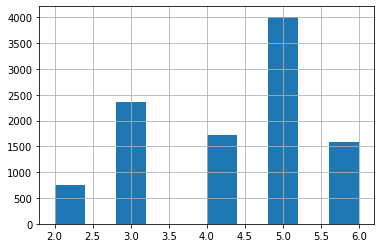

In [100]:
ann_df['Readability and newsworthiness:::Understanding the science news story requires specialized knowledge reversed'].hist()

<Axes: >

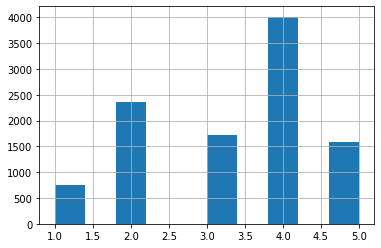

In [126]:
ann_df['Readability and newsworthiness:::Understanding the science news story requires specialized knowledge reversed'].hist()

In [128]:
ann_df['t'] = ann_df['Readability and newsworthiness:::Understanding the science news story requires specialized knowledge reversed'] + ann_df['Readability and newsworthiness:::I can understand the science news story']

<Axes: >

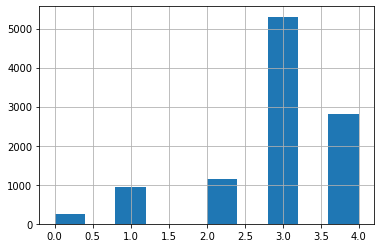

In [125]:
ann_df['Readability and newsworthiness:::I can understand the science news story'].hist()

In [67]:
agg_df.keys()

Index(['instance_id', 'scores', 'std', 'users', 'nonsci_reader_sore',
       'sci_reader_sore', 'scores_num', 'label', 'statement', 'dimension',
       'doi', 'url', 'Mention title', 'category', 'outlet', 'coverage_type',
       'FleschReadingEase', 'big_field', 'single_field', 'cleaned_text',
       'split'],
      dtype='object', name='user')

In [169]:
for k in agg_mapp:
    ann_df[k] = ann_df[agg_mapp[k]].sum(axis=1) / len(agg_mapp[k])

<Axes: >

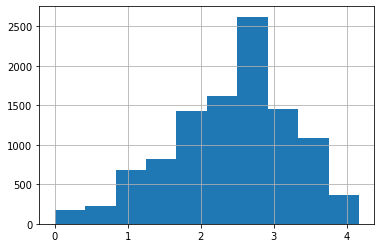

In [170]:
ann_df['Reading'].hist()

In [47]:
ann_df[agg_mapp.keys()]

,Newsworthiness,Publishing,Understandability,Fun,Importance,Interestingness,Sharing,Benefit,Surprisingness,Controversy,Exaggeration
0,3.0,2.500000,1.5,3.0,3.0,3.0,1.666667,2.166667,2.0,3.0,2.0
2,3.0,2.833333,1.5,2.0,3.0,3.0,2.333333,3.000000,3.0,1.0,1.0
5,1.0,1.500000,3.5,1.0,2.0,1.0,1.666667,1.833333,2.0,2.0,2.0
8,2.0,2.333333,2.5,0.0,3.0,2.0,2.000000,2.833333,2.0,1.0,2.0
9,2.0,2.000000,1.5,2.0,2.0,1.5,2.333333,3.000000,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
21449,3.0,2.333333,2.5,0.0,3.0,2.0,0.333333,2.666667,0.0,2.0,1.0
21453,3.0,1.000000,3.5,0.0,2.0,3.0,0.333333,2.166667,1.0,1.0,1.0
21454,4.0,3.166667,1.5,1.0,4.0,3.0,0.666667,3.000000,0.0,3.0,1.0
21455,4.0,3.333333,0.5,2.0,4.0,3.5,1.000000,3.500000,0.0,3.0,1.0


In [11]:
len(set(ann_df.instance_id))

1506

In [12]:
len(ann_df)

10489

In [13]:
ann_df['What is your gender?'].value_counts()

What is your gender?
Woman                     5570
Man                       4690
Non-binary                 115
Prefer not to disclose      65
free_response               45
Name: count, dtype: int64

In [14]:
user_dict[list(user_dict.keys())[0]]

{'What is your gender?': 'Man',
 'How do you describe your race or ethnicity (You may select more than one option)': ['White'],
 'If you choose Asian above, please specify (please choose Not Applicable if you are not Asian)': 'Not Applicable',
 'What is your age?': '35-39',
 'What is your employment status?': 'Employed',
 'What is your education level?': 'High school diploma or equivalent',
 'How frequently do you read science news?': 'Monthly',
 'Which of the following, if any, do you regularly get your science news from (Select all that apply)?': ['Other popular media (e.g. TV and radio)',
  'My normal feed/content/timeline on a social media site (e.g. Facebook, Instagram and Twitter)'],
 'Which, if any, of these science-related topics are you interested in?': ['Engineering (e.g., computer science, transportation engineering)',
  'Humanities (e.g., history, language)'],
 'In general, how much would you say that you trust science?': 'Moderate trust',
 'In general, how much do you trus

In [15]:
user_dict[list(user_dict.keys())[0]]['How frequently do you read science news?']

'Monthly'

<Axes: xlabel='count'>

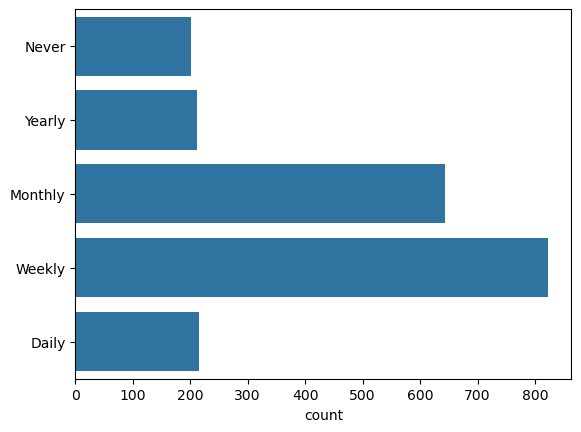

In [16]:
key = 'How frequently do you read science news?'
sns.countplot([user_dict[it][key] if key in user_dict[it] else None for it in user_dict.keys()], order=['Never','Yearly', 'Monthly', 'Weekly', 'Daily'])

In [23]:
sel_key = 'How frequently do you read science news?'
def get_agree_df(ann_df, column):
    a_df =  ann_df.pivot(index='instance_id', columns='user', values=column).sort_values('instance_id').reset_index()#[:-2]
    user_keys = list(set(ann_df['user']))
    p_dict = defaultdict(list)
    for i, row in a_df.iterrows():
        #print('Male',[row[it] for it in user_keys if str(row[it]) != 'nan' and user_dict[it]['gender']=='Male'])
        #print('Female',[row[it] for it in user_keys if str(row[it]) != 'nan' and user_dict[it]['gender']=='Female'])
        #male_s = 
        p_dict['scores'].append([it for it in row[user_keys] if str(it) != 'nan'])
        p_dict['std'].append(statistics.stdev([it for it in row[user_keys] if str(it) != 'nan']))
        p_dict['users'].append([it for it in user_keys if str(row[it]) != 'nan'])
        p_dict['nonsci_reader_sore'].append(get_mean([row[it] for it in user_keys if str(row[it]) != 'nan' and sel_key in user_dict[it] and user_dict[it][sel_key] in ['Monthly', 'Yearly', 'Never']]))
        p_dict['sci_reader_sore'].append(get_mean([row[it] for it in user_keys if str(row[it]) != 'nan' and sel_key in user_dict[it] and user_dict[it][sel_key] in['Weekly', 'Daily']]))
    for key in p_dict:
        a_df[key] = p_dict[key]
    #agree_df['r1'] = [it[0] for it in agree_df['scores']]
    #agree_df['r2'] = [it[1] if len(it) == 2 else '' for it in agree_df['scores']]

    #agree_df['scores'] = p_dict['scores']
    #for key in ['gender']:
    #    agree_df[key] = [[user_dict[it][key] for it in s] for s in p_dict['users']]
    a_df['scores_num'] = [len(s) for s in p_dict['scores']]
    #agree_df['scores_std'] = [np.std(s) for s in p_dict['scores']]
    a_df['label'] = [sum(s)/len(s) if len(s) > 0 else None for s in p_dict['scores']]
    a_df.index = a_df.index.astype(str)
    return a_df

'''
def get_pairwise_ranking_scores(df, key),
    df['rating'] = df[key]
    pairwise_comparisons = defaultdict(int)

    # Iterate through each user's ratings
    for user, group in df.groupby('user'):
        # Generate pairwise comparisons for each user's ratings
        for idx1, idx2 in combinations(group.index, 2):
            instance1, instance2 = df.loc[idx1, 'instance_id'], df.loc[idx2, 'instance_id']
            if df.loc[idx1, 'rating'] > df.loc[idx2, 'rating']:
                pairwise_comparisons[(instance1, instance2)] += 1
            elif df.loc[idx1, 'rating'] < df.loc[idx2, 'rating']:
                pairwise_comparisons[(instance2, instance1)] += 1

    # Convert defaultdict to DataFrame
    pairwise_df = pd.DataFrame(list(pairwise_comparisons.items()), columns=['pair', 'count'])
'''

"\ndef get_pairwise_ranking_scores(df, key),\n    df['rating'] = df[key]\n    pairwise_comparisons = defaultdict(int)\n\n    # Iterate through each user's ratings\n    for user, group in df.groupby('user'):\n        # Generate pairwise comparisons for each user's ratings\n        for idx1, idx2 in combinations(group.index, 2):\n            instance1, instance2 = df.loc[idx1, 'instance_id'], df.loc[idx2, 'instance_id']\n            if df.loc[idx1, 'rating'] > df.loc[idx2, 'rating']:\n                pairwise_comparisons[(instance1, instance2)] += 1\n            elif df.loc[idx1, 'rating'] < df.loc[idx2, 'rating']:\n                pairwise_comparisons[(instance2, instance1)] += 1\n\n    # Convert defaultdict to DataFrame\n    pairwise_df = pd.DataFrame(list(pairwise_comparisons.items()), columns=['pair', 'count'])\n"

In [18]:
sel_cols = ['Readability and newsworthiness:::The science news story sounds interesting to me',
       'Readability and newsworthiness:::Understanding the science news story requires specialized knowledge',
       'Readability and newsworthiness:::The science news story is fun to read',
       'Readability and newsworthiness:::The science news story should be published in the news',
       'Readability and newsworthiness:::The science news story tackles an important issue',
       'Readability and newsworthiness:::I can understand the science news story',
       'Readability and newsworthiness:::The science news story could be interesting to the general public',
       'Practical implications and controversy:::The scientific finding seems surprising to me',
       'Practical implications and controversy:::The scientific finding could be controversial',
       'Practical implications and controversy:::Knowing about this science could benefit a lot of people',
       'Practical implications and controversy:::This science news story is overstated or exaggerated',
       'Practical implications and controversy:::I learned something useful from the science news story',
       'Sharing:::I would share this science news story with someone I know directly',
 'Sharing:::I would share this science news story with a wider forum like a mailing list, twitter, reddit',
 'Sharing:::I would be unlikely to share this science news story with anyone',
 'benefit:::Policy makers',
 'benefit:::A segment of the public',
 'benefit:::Companies in the related industries',
 'benefit:::The general public',
 'publishing:::Other popular media (e.g. TV and radio)',
 'publishing:::Other popular print media (e.g. Vogue, GQ, Elle, People, Time and Reader’s Digest)',
 'publishing:::Science and Technology media (e.g. Scientific American, National Geographic)',
 'publishing:::My normal feed/content/timeline on a social media site (e.g. Facebook, Instagram and Twitter)',
 'publishing:::General news outlets (e.g. BBC, New York Times, Fox News)',
 'publishing:::It should not be published in public media outside the science community'
 ]

sel_cols = [
        'Readability and newsworthiness:::The science news story should be published in the news',
       'Readability and newsworthiness:::The science news story tackles an important issue',
      'Readability and newsworthiness:::I can understand the science news story',
      'Readability and newsworthiness:::The science news story could be interesting to the general public',
    'Practical implications and controversy:::Knowing about this science could benefit a lot of people',
       'Readability and newsworthiness:::The science news story is fun to read', 
       'Practical implications and controversy:::The scientific finding seems surprising to me',
       
 'Sharing:::I would share this science news story with a wider forum like a mailing list, twitter, reddit'
 ]



In [24]:
import warnings

warnings.filterwarnings('ignore')

In [171]:
sel_cols = list(agg_mapp.keys())
#sel_cols = [it for it in ann_df.columns if it.split(':::')[0] in ['Readability and newsworthiness', 'Practical implications and controversy']]
agree_df = None
user_keys = set(ann_df.user)
bad_users = []
sel_users = [it for it in user_keys if it not in bad_users]
t_df = ann_df[~ann_df['user'].isin(bad_users)]

agg_df = pd.DataFrame()
full_df = pd.DataFrame()
agree_res = defaultdict(list)
for i,col in enumerate(sel_cols):
    c_df = get_agree_df(t_df, col)
    c_df['statement'] = col
    print(col)
    #c_df = c_df[c_df['scores_num']>=2]
    full_df = pd.concat([full_df, c_df])
    #print(col.split(':::')[1], '#',krippendorff.alpha(np.array(c_df[sel_users]).transpose(), level_of_measurement='ordinal'), split_half_corr(c_df, key='scores'))
    agree_res['type'].append(col.split(':::')[0])
    agree_res['statement'].append(col.split(':::')[0])
    agree_res['alpha'].append(krippendorff.alpha(np.array(c_df[sel_users]).transpose(), level_of_measurement='ordinal'))
    agree_res['female_alpha'].append(krippendorff.alpha(np.array(c_df[list(user_df[user_df['What is your gender?']=='Woman']['user_id'])]).transpose(), level_of_measurement='ordinal'))
    agree_res['male_alpha'].append(krippendorff.alpha(np.array(c_df[list(user_df[user_df['What is your gender?']=='Man']['user_id'])]).transpose(), level_of_measurement='ordinal'))
    #agree_res['shr'].append(split_half_corr(c_df, key='scores'))
    print(col, '#',krippendorff.alpha(np.array(c_df[sel_users]).transpose(), level_of_measurement='ordinal'))
    

    c_df = c_df.drop(columns=sel_users)
    c_df['dimension'] = col
    agg_df = pd.concat([agg_df, c_df])
    
    a_df = c_df
    a_df.columns = [it + '_'+col if it not in ['instance_id', 'user'] else it for it in list(a_df.columns)]
    if i==0:
        agree_df = a_df
        #agree_df.columns = [it + '_'+col if it not in ['instance_id'] else it for it in list(c_df.columns)]
    else:
        for key in a_df.columns:
            agree_df[key] = a_df[key]
    
agree_res = pd.DataFrame(agree_res)        
    
agree_df['text'] = [data_dict[it]['text'] for it in agree_df['instance_id']]
agree_df['Mention title'] = [data_dict[it]['Mention title'] for it in agree_df['instance_id']]
agree_df['category'] = [data_dict[it]['category'] for it in agree_df['instance_id']]

for key in ['doi', 'url']:
    agg_df[key] = [data_dict[it][key] for it in agg_df['instance_id']]

agg_df['Mention title'] = [data_dict[it]['Mention title'] for it in agg_df['instance_id']]
agg_df['category'] = [data_dict[it]['category'] for it in agg_df['instance_id']]
agg_df['outlet'] = [data_dict[it]['outlet'] for it in agg_df['instance_id']]
agg_df['coverage_type'] = [data_dict[it]['coverage_type'] for it in agg_df['instance_id']]
agg_df['statement'] = [it.split(':::')[0] for it in agg_df['dimension']]
agg_df['FleschReadingEase'] = [data_dict[it]['FleschReadingEase'] for it in agg_df['instance_id']]
agg_df['big_field'] = [data_dict[it]['big_field'] for it in agg_df['instance_id']]
    



Newsworthiness
Newsworthiness # 0.1362425717989154
Reading
Reading # 0.08029401576382322
Understandability
Understandability # 0.20052648223398772
Expertise
Expertise # 0.26696053787743135
Fun
Fun # 0.12709897074924248
Importance
Importance # 0.3222671532594562
Interestingness
Interestingness # 0.13359290038084648
Sharing
Sharing # 0.05018697154304397
Benefit
Benefit # 0.21103207904487442
Surprisingness
Surprisingness # 0.08805149743123974
Controversy
Controversy # 0.15102063489542594
Exaggeration
Exaggeration # 0.047679266411804866


In [172]:
agree_res = defaultdict(list)
for i,col in enumerate(sel_cols):
    c_df = full_df[full_df['statement']==col]
    c_df['statement'] = col
    print(col)
    #c_df = c_df[c_df['scores_num']>=2]
    full_df = pd.concat([full_df, c_df])
    #print(col.split(':::')[1], '#',krippendorff.alpha(np.array(c_df[sel_users]).transpose(), level_of_measurement='ordinal'), split_half_corr(c_df, key='scores'))
    agree_res['type'].append(col.split(':::')[0])
    agree_res['statement'].append(col.split(':::')[0])
    agree_res['alpha'].append(krippendorff.alpha(np.array(c_df[sel_users]).transpose(), level_of_measurement='ordinal'))
    agree_res['female_alpha'].append(krippendorff.alpha(np.array(c_df[list(user_df[user_df['What is your gender?']=='Woman']['user_id'])]).transpose(), level_of_measurement='ordinal'))
    agree_res['male_alpha'].append(krippendorff.alpha(np.array(c_df[list(user_df[user_df['What is your gender?']=='Man']['user_id'])]).transpose(), level_of_measurement='ordinal'))
    #agree_res['white_alpha'].append(krippendorff.alpha(np.array(c_df[list(user_df[user_df['How do you describe your race or ethnicity (You may select more than one option)']=='[White]']['user_id'])].replace(np.nan, None).dropna(axis=0, how='all')).replace(None, np.nana).transpose(), level_of_measurement='ordinal'))
    #agree_res['nonwhite_alpha'].append(krippendorff.alpha(np.array(c_df[list(user_df[user_df['How do you describe your race or ethnicity (You may select more than one option)']!='[White]']['user_id'])]).transpose(), level_of_measurement='ordinal'))
    agree_res['nonsci_reader_alpha'].append(krippendorff.alpha(np.array(c_df[list(user_df[user_df['How frequently do you read science news?'].isin(['Monthly', 'Yearly', 'Never'])]['user_id'])]).transpose(), level_of_measurement='ordinal'))
    agree_res['sci_reader_alpha'].append(krippendorff.alpha(np.array(c_df[list(user_df[user_df['How frequently do you read science news?'].isin(['Daily','Weekly'])]['user_id'])]).transpose(), level_of_measurement='ordinal'))


Newsworthiness
Reading
Understandability
Expertise
Fun
Importance
Interestingness
Sharing
Benefit
Surprisingness
Controversy
Exaggeration


In [173]:
pd.DataFrame(agree_res)

,type,statement,alpha,female_alpha,male_alpha,nonsci_reader_alpha,sci_reader_alpha
0,Newsworthiness,Newsworthiness,0.136243,0.155422,0.114897,0.133397,0.130044
1,Reading,Reading,0.080294,0.094274,0.062298,0.085811,0.076242
2,Understandability,Understandability,0.200526,0.245156,0.149321,0.243444,0.151876
3,Expertise,Expertise,0.266961,0.299333,0.231538,0.291950,0.260373
4,Fun,Fun,0.127099,0.125328,0.125639,0.135172,0.140244
5,Importance,Importance,0.322267,0.335276,0.312269,0.329946,0.330026
6,Interestingness,Interestingness,0.133593,0.163197,0.095721,0.156764,0.119773
7,Sharing,Sharing,0.050187,0.067178,0.047087,0.077996,0.048140
8,Benefit,Benefit,0.211032,0.209665,0.197019,0.224155,0.204264
9,Surprisingness,Surprisingness,0.088051,0.100059,0.055047,0.070452,0.087782


In [174]:
agree_df['single_field'] =  [data_dict[it]['single_field'] for it in agree_df['instance_id']]
agree_df['big_field'] =  [data_dict[it]['big_field'] for it in agree_df['instance_id']]

In [175]:
agree_df.to_csv('annotation_output/full/agg/agree_df.csv')

In [176]:
sel_cols

['Newsworthiness',
 'Reading',
 'Understandability',
 'Expertise',
 'Fun',
 'Importance',
 'Interestingness',
 'Sharing',
 'Benefit',
 'Surprisingness',
 'Controversy',
 'Exaggeration']

In [113]:
#user_df.to_csv('annotation_output/full/user_df.csv', index=False)

In [114]:
#all_df.drop_duplicates('user')['sample'].value_counts()

In [177]:
agg_df['single_field'] = [data_dict[it]['single_field'] for it in agg_df['instance_id']]


In [178]:
agg_df['cleaned_text'] = [data_dict[it]['cleaned_text'] for it in agg_df['instance_id']]
#agg_df['statement_full'] = agg_df['statement']
#agg_df['statement'] = [s2s[it] for it in agg_df['statement_full']]

In [179]:
agg_df['split'] = [data_dict[it]['split'] for it in agg_df['instance_id']]

In [180]:
len(set(agg_df.cleaned_text))

1506

In [181]:
agg_df = agg_df[~agg_df.label.isna()]

In [182]:
#agg_df.drop(columns=['cleaned_text']).to_csv('annotation_output/full/batch_1/agg_df.csv',index=False)
agg_df.to_csv('annotation_output/full/agg/agg_df_with_full_text.csv',index=False)

In [167]:
agg_df.statement.value_counts()

statement
Newsworthiness       1506
Publishing           1506
Understandability    1506
Expertise            1506
Fun                  1506
Importance           1506
Interestingness      1506
Sharing              1506
Benefit              1506
Surprisingness       1506
Controversy          1506
Exaggeration         1506
Name: count, dtype: int64

In [69]:
agg_df['label']

0       1.571429
1       3.333333
2       3.000000
3       1.571429
4       2.875000
          ...   
1499    1.000000
1500    1.333333
1501    2.333333
1502    1.333333
1503    0.666667
Name: label, Length: 37600, dtype: float64

In [81]:
df4model[['instance_id','cleaned_text','labels','split']].to_csv('merged.csv')

In [82]:
df4model.dropna()

user,instance_id,scores,users,scores_num,label,dimension,doi,url,Mention title,category,...,Could benefit many people,Other popular media,Would share on wider forum,Should be published in news,I understand the news story,Policy makers,General public,Unlikely to share,Could interest the general public,labels
0,1_0,"[1.0, 2.0, 3.0, 0.0, 3.0, 1.0, 1.0]","[5c5d36bc034e280001644c3b, 63e52debbbb982734de...",7,1.571429,Readability and newsworthiness:::The science n...,10.1073/pnas.1817972116,http://ct.moreover.com/?a=39160635436&p=1pl&v=...,Origin of Sino-Tibetan language family reveale...,PressRelease,...,1.428571,1.000000,0.714286,2.000000,2.142857,1.714286,1.142857,3.571429,1.857143,"[1.5714285714285714, 1.7142857142857142, 0.857..."
1,1_1,"[3.0, 3.0, 3.0, 4.0, 4.0, 3.0]","[6228f5506248f4f80a39008a, 6482b253bee377ae5ad...",6,3.333333,Readability and newsworthiness:::The science n...,10.1126/science.aat9446,http://ct.moreover.com/?a=37917482337&p=1pl&v=...,Researchers explore new way of killing malaria...,General,...,3.000000,2.666667,1.166667,2.666667,3.500000,3.000000,3.166667,1.833333,2.833333,"[3.1666666666666665, 1.8333333333333333, 1.666..."
2,1_10,"[2.0, 4.0, 2.0, 2.0, 4.0, 3.0, 4.0]","[61041a47bf8d4cc6be6c3a03, 6318be45a49442eee3a...",7,3.000000,Readability and newsworthiness:::The science n...,10.1177/1745691615596788,http://psychcentral.com/news/2015/11/19/parent...,Parents’ Concerns about Teens Online Are Often...,SciTech,...,2.428571,2.571429,2.142857,2.857143,3.142857,2.428571,2.714286,1.571429,2.714286,"[2.142857142857143, 1.2857142857142858, 2.4285..."
3,1_100,"[3.0, 0.0, 0.0, 1.0, 2.0, 3.0, 2.0]","[5a9ad69adbdb470001eee577, 5dda6f4e82569a9cea9...",7,1.571429,Readability and newsworthiness:::The science n...,10.1002/oby.20697,http://www.newswise.com/articles/smoking-may-d...,Smoking May Dull Obese Women's Ability to Tast...,PressRelease,...,1.714286,1.428571,0.857143,2.000000,2.857143,2.000000,2.142857,2.428571,2.142857,"[1.8571428571428572, 0.8571428571428571, 1.142..."
4,1_101,"[2.0, 4.0, 3.0, 3.0, 4.0, 3.0, 2.0, 2.0]","[5f8ac88921cb9c17d0fb37b1, 63c949f6ecb7d04be0d...",8,2.875000,Readability and newsworthiness:::The science n...,10.1002/oby.20697,http://www.scienceworldreport.com/articles/138...,Obese Smokers Less Likely to Detect Fat and Su...,SciTech,...,2.750000,2.125000,1.875000,2.750000,3.125000,2.625000,2.500000,2.500000,3.125000,"[2.875, 1.0, 2.25, 3.0, 2.25, 3.25, 1.375, 2.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,2_99,"[4.0, 4.0, 2.0]","[644857a2d21eca3ffb31101e, 5ce1f31a27efac00188...",3,3.333333,Readability and newsworthiness:::The science n...,10.1177/0956797613514092,http://www.technology.org/2014/04/04/lack-mate...,Lack of Material Resources Causes Harsher Mora...,PressRelease,...,2.666667,2.000000,2.333333,2.666667,2.666667,2.333333,2.333333,2.333333,3.333333,"[2.6666666666666665, 1.0, 2.0, 2.6666666666666..."
1500,2_990,"[3.0, 2.0, 2.0]","[5d41e832b0ca7200169d857e, 5c745295821a9700176...",3,2.333333,Readability and newsworthiness:::The science n...,10.1098/rsif.2013.1211,http://www.theepochtimes.com/n3/524112-do-soci...,Do Social Networks Make Us Lazy Thinkers?,General,...,2.666667,2.000000,2.333333,2.333333,2.666667,2.333333,3.000000,1.333333,2.333333,"[2.6666666666666665, 1.6666666666666667, 2.0, ..."
1501,2_991,"[3.0, 0.0, 1.0]","[5e84f020507cd30b367b2624, 6095fc75ab1d101e060...",3,1.333333,Readability and newsworthiness:::The science n...,10.1098/rsif.2013.1211,http://www.technology.org/2014/02/24/oregon-st...,"Oregon study: Imitation is flattery, but it li...",PressRelease,...,1.666667,1.666667,0.666667,1.333333,2.000000,2.000000,2.333333,2.666667,2.000000,"[1.6666666666666667, 2.0, 0.6666666666666666, ..."
1502,2_992,"[3.0, 1.0, 1.0]","[5dbb4449b4715a13fa2ffbed, 652eb2803da3707d852...",3,1.666667,Readability and newsworthiness:::The science n...,10.1016/s2214-109x(14)70245-1,http://www.sciencedaily.com/releases/2014/07/1...,Incidence of

In [35]:
df4model, statements = prepare_data4model(agg_df)

train    1054
test      302
val       150
Name: split, dtype: int64


In [538]:
agree_res.to_csv('annotation_output/full/batch_1/agree_res.csv',index=False)

In [127]:
s2s

{'The science news story sounds interesting to me': 'News story is interesting to me',
 'Understanding the science news story requires specialized knowledge': 'Needs specialized knowledge',
 'The science news story is fun to read': 'News story is fun to read',
 'The science news story should be published in the news': 'Should be published in news',
 'The science news story tackles an important issue': 'Tackles an important issue',
 'I can understand the science news story': 'I understand the news story',
 'The science news story could be interesting to the general public': 'Could interest the general public',
 'The scientific finding seems surprising to me': 'Finding is surprising to me',
 'The scientific finding could be controversial': 'Finding could be controversial',
 'Knowing about this science could benefit a lot of people': 'Could benefit many people',
 'This science news story is overstated or exaggerated': 'News story is exaggerated',
 'I learned something useful from the scie

In [623]:
static_cols

['How frequently do you read science news?',
 'Please feel free to leave any comments about our study (optional)',
 'instance_id',
 'In general, how much do you trust scientists to find out accurate information about the world?',
 'How much do you know about what scientists do?',
 'displayed_text',
 'Please rate the following statements: Individuals should have the right to define their own gender identity and marry whomever they choose.',
 'I have read and understood the instructions.',
 'If you choose Asian above, please specify (please choose Not Applicable if you are not Asian)',
 'How do you feel about your experience participating our study compared with other studies?',
 'Which of the following, if any, do you regularly get your science news from (Select all that apply)?',
 'Please rate the following statements: Drugs, especially softer ones like marijuana, should be decriminalized or legalized.',
 'Please rate the following statements: The government should actively intervene i

In [109]:
static_cols = list(set(ann_df.columns)-set(sel_cols))


In [110]:
[it for it in static_cols if it[0] == 'P']

['Please rate the following statements: Women should have the complete right to make decisions about their reproductive health, including access to abortion.',
 'Please rate the following statements: Drugs, especially softer ones like marijuana, should be decriminalized or legalized.',
 'Please feel free to leave any comments about our study (optional)',
 'Please rate the following statements: Government should invest heavily in public services like healthcare, education, and welfare.',
 'Please rate the following statements: Individuals should have the right to define their own gender identity and marry whomever they choose.',
 'Please rate the following statements: Wealthy individuals and corporations should pay a higher tax rate to fund public services.',
 'Please rate the following statements: The government should actively intervene in the market to ensure equality and consumer protection.']

In [184]:
all_df = pd.DataFrame()
static_cols = list(set(ann_df.columns)-set(sel_cols))
for c in sel_cols:
    t_df = ann_df[static_cols]
    t_df['score'] = list(ann_df[c])
    t_df['statement'] = c.split(':::')[0]
    all_df = pd.concat([all_df,t_df])
    

In [185]:
all_df['Mention title'] = [data_dict[it]['Mention title'] for it in all_df['instance_id']]
all_df['category'] = [data_dict[it]['category'] for it in all_df['instance_id']]
all_df['outlet'] = [data_dict[it]['outlet'] for it in all_df['instance_id']]
all_df['coverage_type'] = [data_dict[it]['coverage_type'] for it in all_df['instance_id']]
all_df['big_field'] = [data_dict[it]['big_field'] for it in all_df['instance_id']]
all_df['mention_year'] = [data_dict[it]['mention_year'] for it in all_df['instance_id']]
all_df['doi'] = [data_dict[it]['doi'] for it in all_df['instance_id']]


In [113]:
#all_df = all_df.rename(columns = q2q)

In [187]:
all_df['cleaned_text'] = [data_dict[it]['cleaned_text'] for it in all_df['instance_id']]
all_df['statement'] =[it for it in all_df['statement']]

In [23]:
#all_df['split'] = split_labels(len(all_df), ratio=[0.7,0.1,0.2])

In [189]:
all_df.to_csv('annotation_output/full/all_df.csv',index=False)
#all_df.to_csv('annotation_output/full/batch_1/all_df_with_full_text.csv',index=False)

[Text(0.5, 0, 'News story is interesting to me'),
 Text(1.5, 0, 'Needs specialized knowledge'),
 Text(2.5, 0, 'News story is fun to read'),
 Text(3.5, 0, 'Should be published in news'),
 Text(4.5, 0, 'Tackles an important issue'),
 Text(5.5, 0, 'I understand the news story'),
 Text(6.5, 0, 'Could interest the general public'),
 Text(7.5, 0, 'Finding is surprising to me'),
 Text(8.5, 0, 'Finding could be controversial'),
 Text(9.5, 0, 'Could benefit many people'),
 Text(10.5, 0, 'News story is exaggerated'),
 Text(11.5, 0, 'I learned something useful'),
 Text(12.5, 0, 'Would share directly'),
 Text(13.5, 0, 'Would share on wider forum'),
 Text(14.5, 0, 'Unlikely to share'),
 Text(15.5, 0, 'Policy makers'),
 Text(16.5, 0, 'A public segment'),
 Text(17.5, 0, 'Related industry companies'),
 Text(18.5, 0, 'General public'),
 Text(19.5, 0, 'Other popular media'),
 Text(20.5, 0, 'Popular print media'),
 Text(21.5, 0, 'Sci-Tech media'),
 Text(22.5, 0, 'My social media feed'),
 Text(23.5, 0, 'G

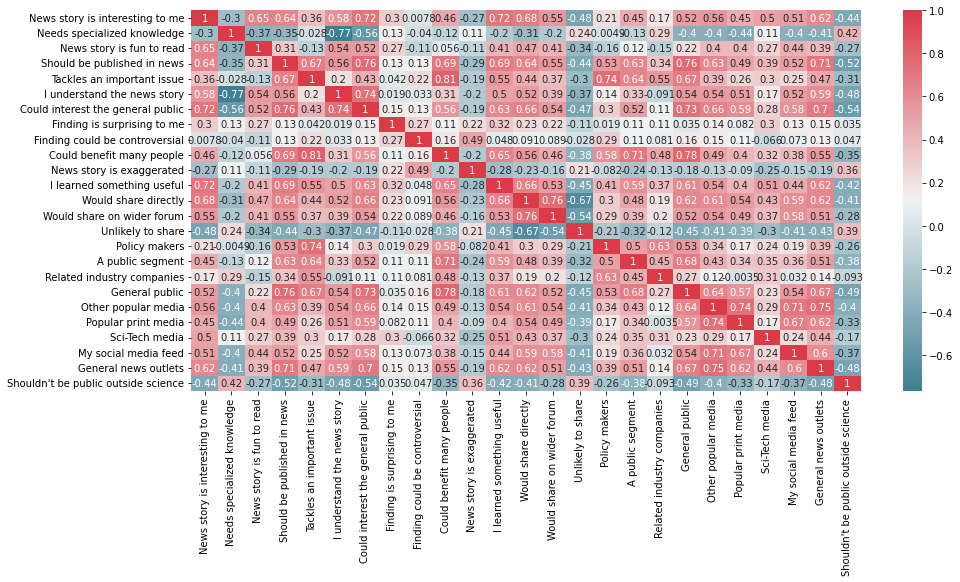

In [68]:

heat_dict = defaultdict(list)
for col in sel_cols[:]:
    for c in sel_cols[:]:
        #try:
        heat_dict[s2s[col.split(':::')[1]]].append(agree_df['label_' + col].corr(agree_df['label_' + c]))
        #except:
        #    continue
heat_df = pd.DataFrame(heat_dict)
heat_df.index=[ s2s[col.split(':::')[1]] for col in sel_cols[:]]

fig, ax = plt.subplots(figsize=(15,7))     

# Define a custom color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create the heatmap
ax = sns.heatmap(heat_df, annot=True, cmap=cmap)

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Show the plot
#plt.show()

Text(0.5, 58.7222222222222, 'score')

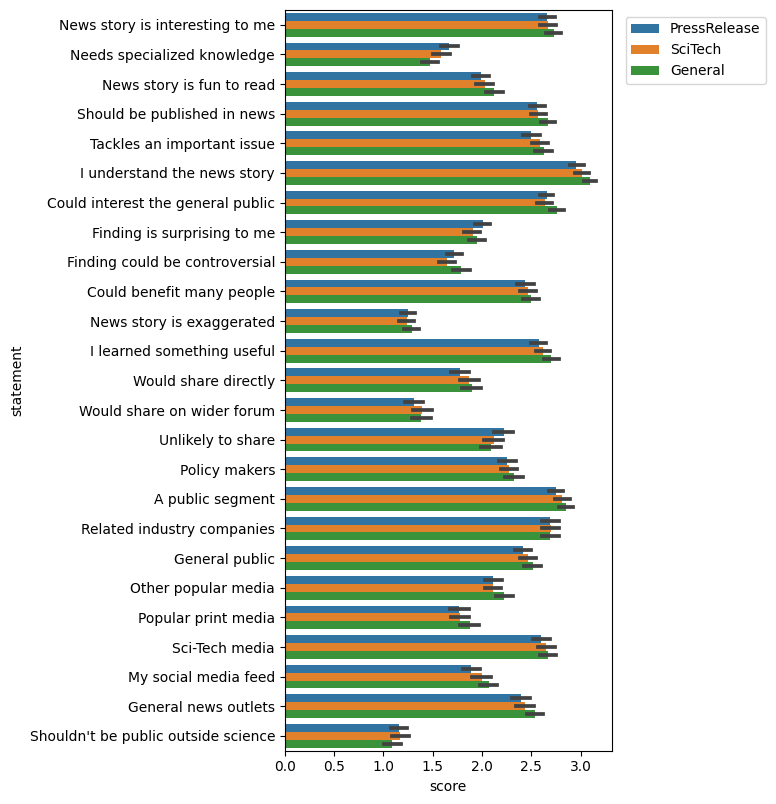

In [42]:
#all_df['statement'] = [s2s[it] for it in all_df['statement']]
fig, axes = plt.subplots(figsize=(4,8))
plt.tight_layout()
sns.barplot(x='score', y='statement', hue='category',data=all_df[all_df.coverage_type=='all_covered'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xlabel('score')

<Axes: xlabel='label', ylabel='single_field'>

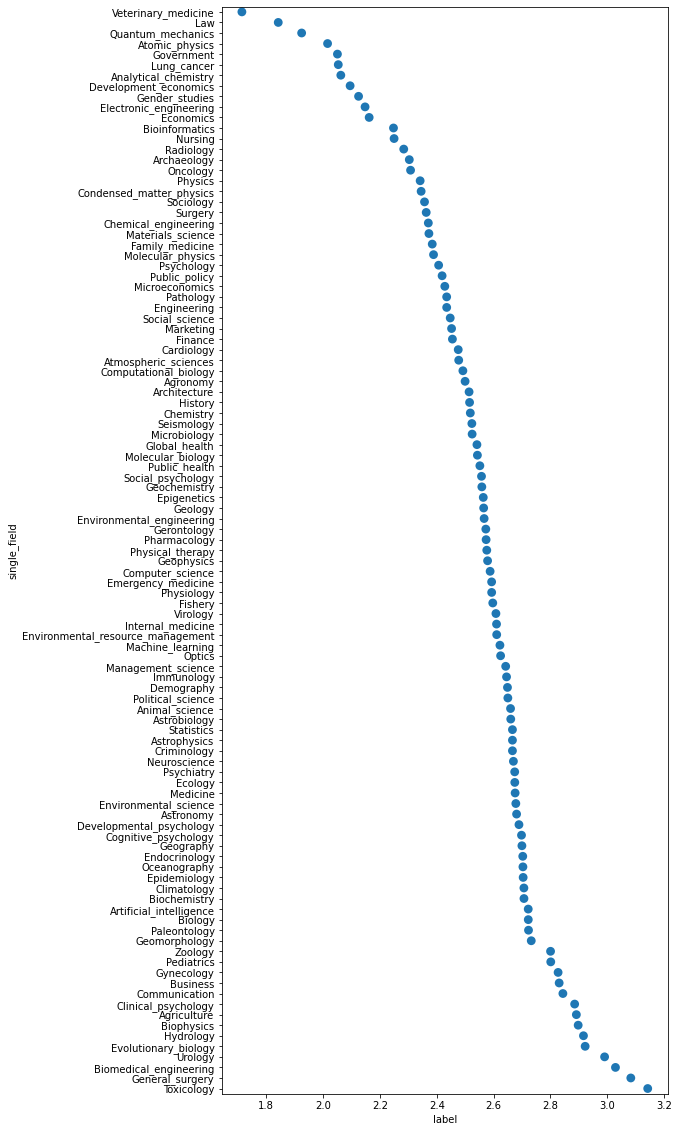

In [133]:
key = 'The science news story sounds interesting to me'
fig, ax = plt.subplots(figsize=(8, 20)) 
sns.pointplot(y='single_field', x='label', data=agg_df[agg_df['statement_full']==key][['single_field','label']].groupby('single_field').mean().reset_index().sort_values('label'), join=False)

In [120]:
t_df = all_df[all_df.big_field!='Others'].reset_index().pivot_table(index='statement',columns='big_field',values='score')
t_df = t_df.reindex(s2s.values())#.transpose()

[Text(0.5, 0, 'Engineering'),
 Text(1.5, 0, 'Humanities'),
 Text(2.5, 0, 'Medicine'),
 Text(3.5, 0, 'Science'),
 Text(4.5, 0, 'Social Science')]

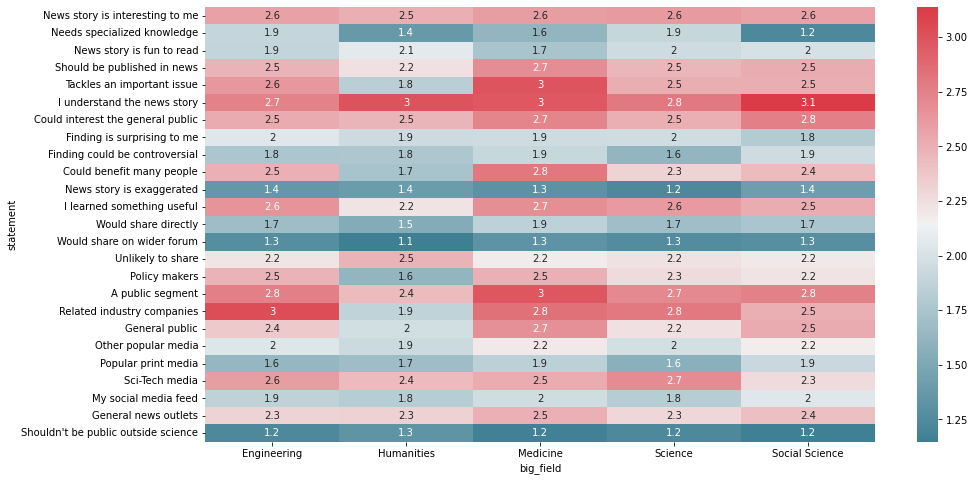

In [121]:
fig, ax = plt.subplots(figsize=(15,8))     

# Define a custom color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)


# Create the heatmap
ax = sns.heatmap(t_df, annot=True, cmap=cmap)

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

Text(0.5, 51.0, 'score')

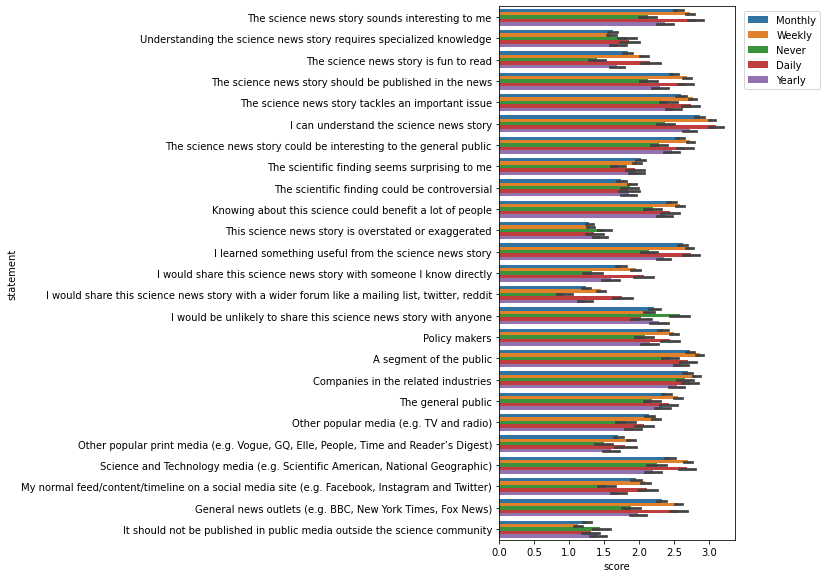

In [443]:
fig, axes = plt.subplots(figsize=(4,8))
plt.tight_layout()
sns.barplot(x='score', y='statement', hue='How frequently do you read science news?',data=all_df)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xlabel('score')

[Text(0.5, 0, 'No clue'),
 Text(1.5, 0, 'limited'),
 Text(2.5, 0, 'Some'),
 Text(3.5, 0, 'Good'),
 Text(4.5, 0, 'Expert')]

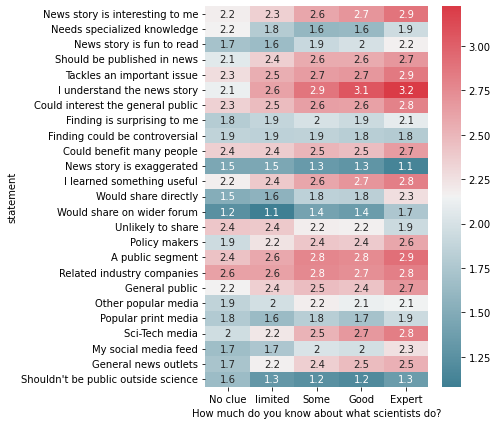

In [645]:
key = 'How much do you know about what scientists do?'
fig, ax = plt.subplots(figsize=(5,7))     

# Define a custom color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create the heatmap
ax = sns.heatmap(all_df.reset_index().pivot_table(index='statement',columns=key,values='score')[question_dict[key]['choices']].reindex(s2s.values()), annot=True, cmap=cmap)

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

[Text(0.5, 0, 'Never'),
 Text(1.5, 0, 'Yearly'),
 Text(2.5, 0, 'Monthly'),
 Text(3.5, 0, 'Weekly'),
 Text(4.5, 0, 'Daily')]

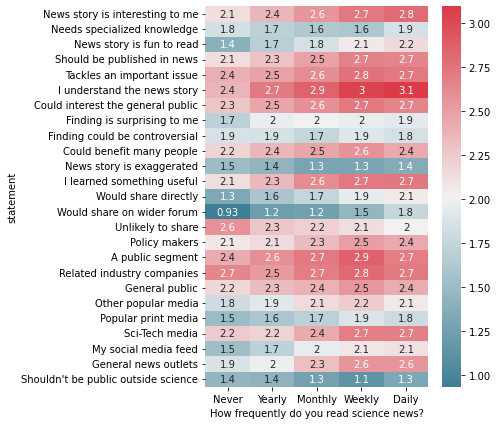

In [582]:
key = 'How frequently do you read science news?'
fig, ax = plt.subplots(figsize=(5,7))     

# Define a custom color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create the heatmap
ax = sns.heatmap(all_df.reset_index().pivot_table(index='statement',columns=key,values='score')[reversed(question_dict[key]['choices'])].reindex(s2s.values()), annot=True, cmap=cmap)

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

[Text(0.5, 0, 'No trust'),
 Text(1.5, 0, 'Little trust'),
 Text(2.5, 0, 'Some trust'),
 Text(3.5, 0, 'Moderate trust'),
 Text(4.5, 0, 'High trust'),
 Text(5.5, 0, 'Complete trust')]

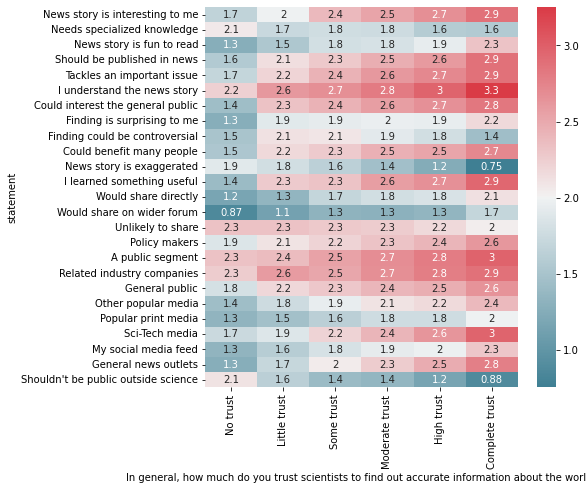

In [458]:
key = 'In general, how much do you trust scientists to find out accurate information about the world?'
fig, ax = plt.subplots(figsize=(7,7))     

# Define a custom color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create the heatmap
ax = sns.heatmap(all_df.reset_index().pivot_table(index='statement',columns=key,values='score')[question_dict[key]['choices']].reindex(s2s.values()), annot=True, cmap=cmap)

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0.5, 0, 'No trust'),
 Text(1.5, 0, 'Little trust'),
 Text(2.5, 0, 'Some trust'),
 Text(3.5, 0, 'Moderate trust'),
 Text(4.5, 0, 'High trust'),
 Text(5.5, 0, 'Complete trust')]

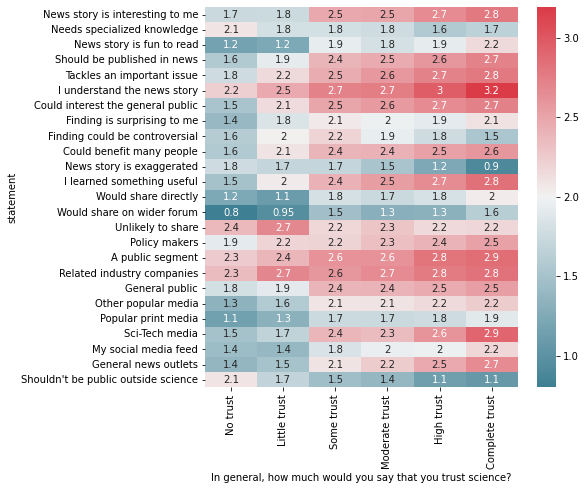

In [476]:
key = 'In general, how much would you say that you trust science?'
fig, ax = plt.subplots(figsize=(7,7))     

# Define a custom color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create the heatmap
ax = sns.heatmap(all_df.reset_index().pivot_table(index='statement',columns=key,values='score')[question_dict[key]['choices']].reindex(s2s.values()), annot=True, cmap=cmap)

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Text(0.5, 42.0, "Women's full rights on reproductive health & abortion access.")

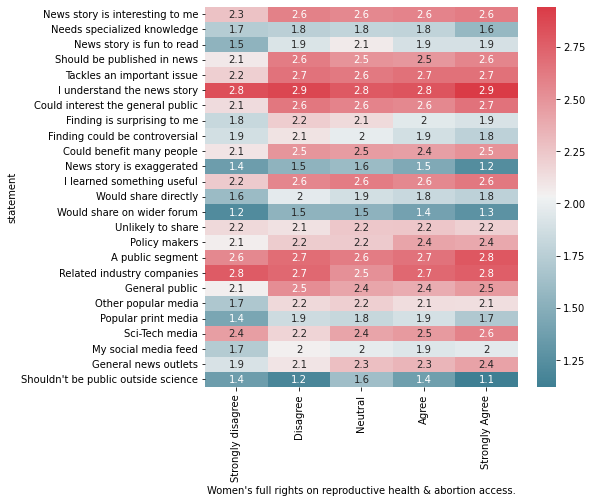

In [648]:
key = 'Please rate the following statements: Women should have the complete right to make decisions about their reproductive health, including access to abortion.'
fig, ax = plt.subplots(figsize=(7,7))     

# Define a custom color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create the heatmap
ax = sns.heatmap(all_df.reset_index().pivot_table(index='statement',columns=key,values='score')[question_dict[key]['choices']].reindex(s2s.values()), annot=True, cmap=cmap)

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel(q2q[key])

Text(0.5, 42.0, 'Decriminalization/legalization of drugs, especially marijuana.')

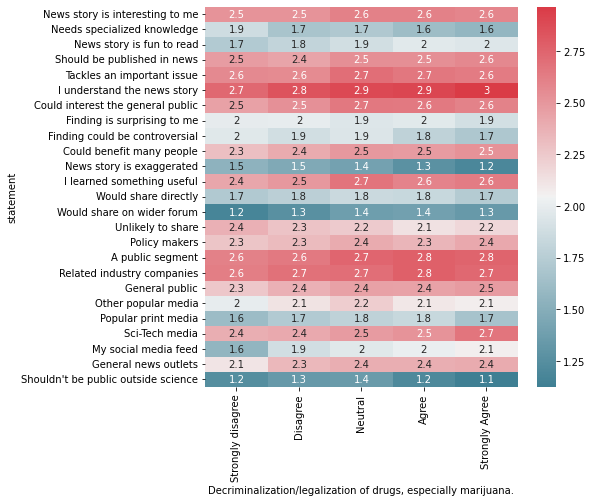

In [649]:
key = 'Please rate the following statements: Drugs, especially softer ones like marijuana, should be decriminalized or legalized.'
fig, ax = plt.subplots(figsize=(7,7))     

# Define a custom color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create the heatmap
ax = sns.heatmap(all_df.reset_index().pivot_table(index='statement',columns=key,values='score')[question_dict[key]['choices']].reindex(s2s.values()), annot=True, cmap=cmap)

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel(q2q[key])

In [480]:
all_df['Please rate the following statements: Individuals should have the right to define their own gender identity and marry whomever they choose.'].value_counts()

Please rate the following statements: Individuals should have the right to define their own gender identity and marry whomever they choose.
Strongly Agree       34825
Agree                24300
Neutral              18100
Disagree              7250
Strongly disagree     6500
Name: count, dtype: int64

[Text(0.5, 0, 'Strongly disagree'),
 Text(1.5, 0, 'Disagree'),
 Text(2.5, 0, 'Neutral'),
 Text(3.5, 0, 'Agree'),
 Text(4.5, 0, 'Strongly Agree')]

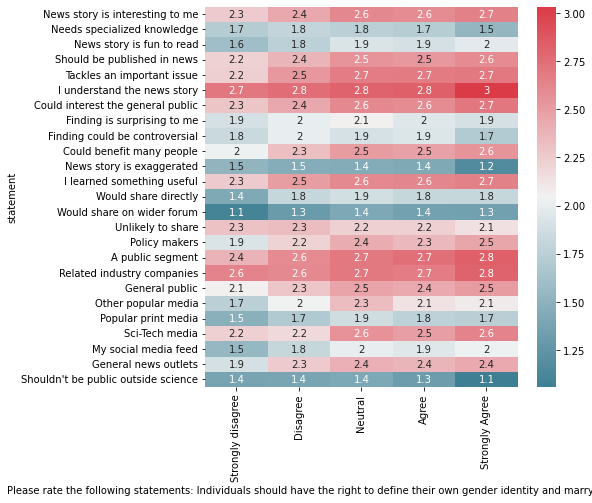

In [481]:
key = 'Please rate the following statements: Individuals should have the right to define their own gender identity and marry whomever they choose.'
fig, ax = plt.subplots(figsize=(7,7))     

# Define a custom color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create the heatmap
ax = sns.heatmap(all_df.reset_index().pivot_table(index='statement',columns=key,values='score')[question_dict[key]['choices']].reindex(s2s.values()), annot=True, cmap=cmap)

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0.5, 0, 'UK'), Text(1.5, 0, 'US')]

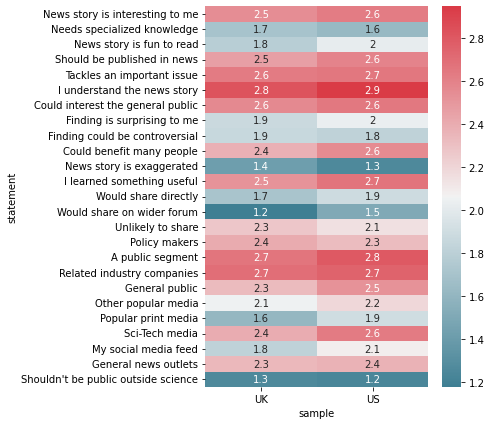

In [466]:
key = 'sample'
fig, ax = plt.subplots(figsize=(5,7))     

# Define a custom color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create the heatmap
ax = sns.heatmap(all_df.reset_index().pivot_table(index='statement',columns=key,values='score').reindex(s2s.values()), annot=True, cmap=cmap)

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

[Text(0.5, 0, '2013'),
 Text(1.5, 0, '2014'),
 Text(2.5, 0, '2015'),
 Text(3.5, 0, '2016'),
 Text(4.5, 0, '2017'),
 Text(5.5, 0, '2018'),
 Text(6.5, 0, '2019')]

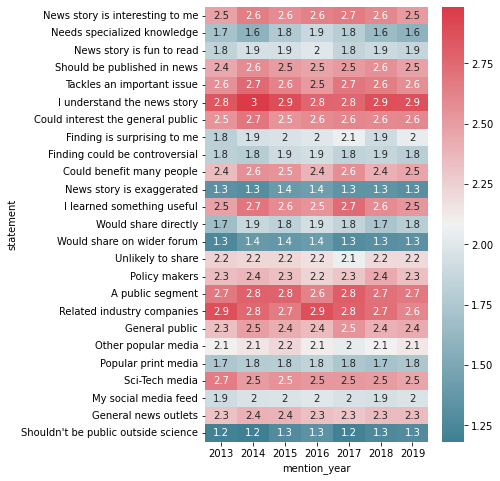

In [487]:
key = 'mention_year'
fig, ax = plt.subplots(figsize=(5,8))     

# Define a custom color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create the heatmap
ax = sns.heatmap(all_df[all_df.mention_year>2012].reset_index().pivot_table(index='statement',columns=key,values='score').reindex(s2s.values()), annot=True, cmap=cmap)

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

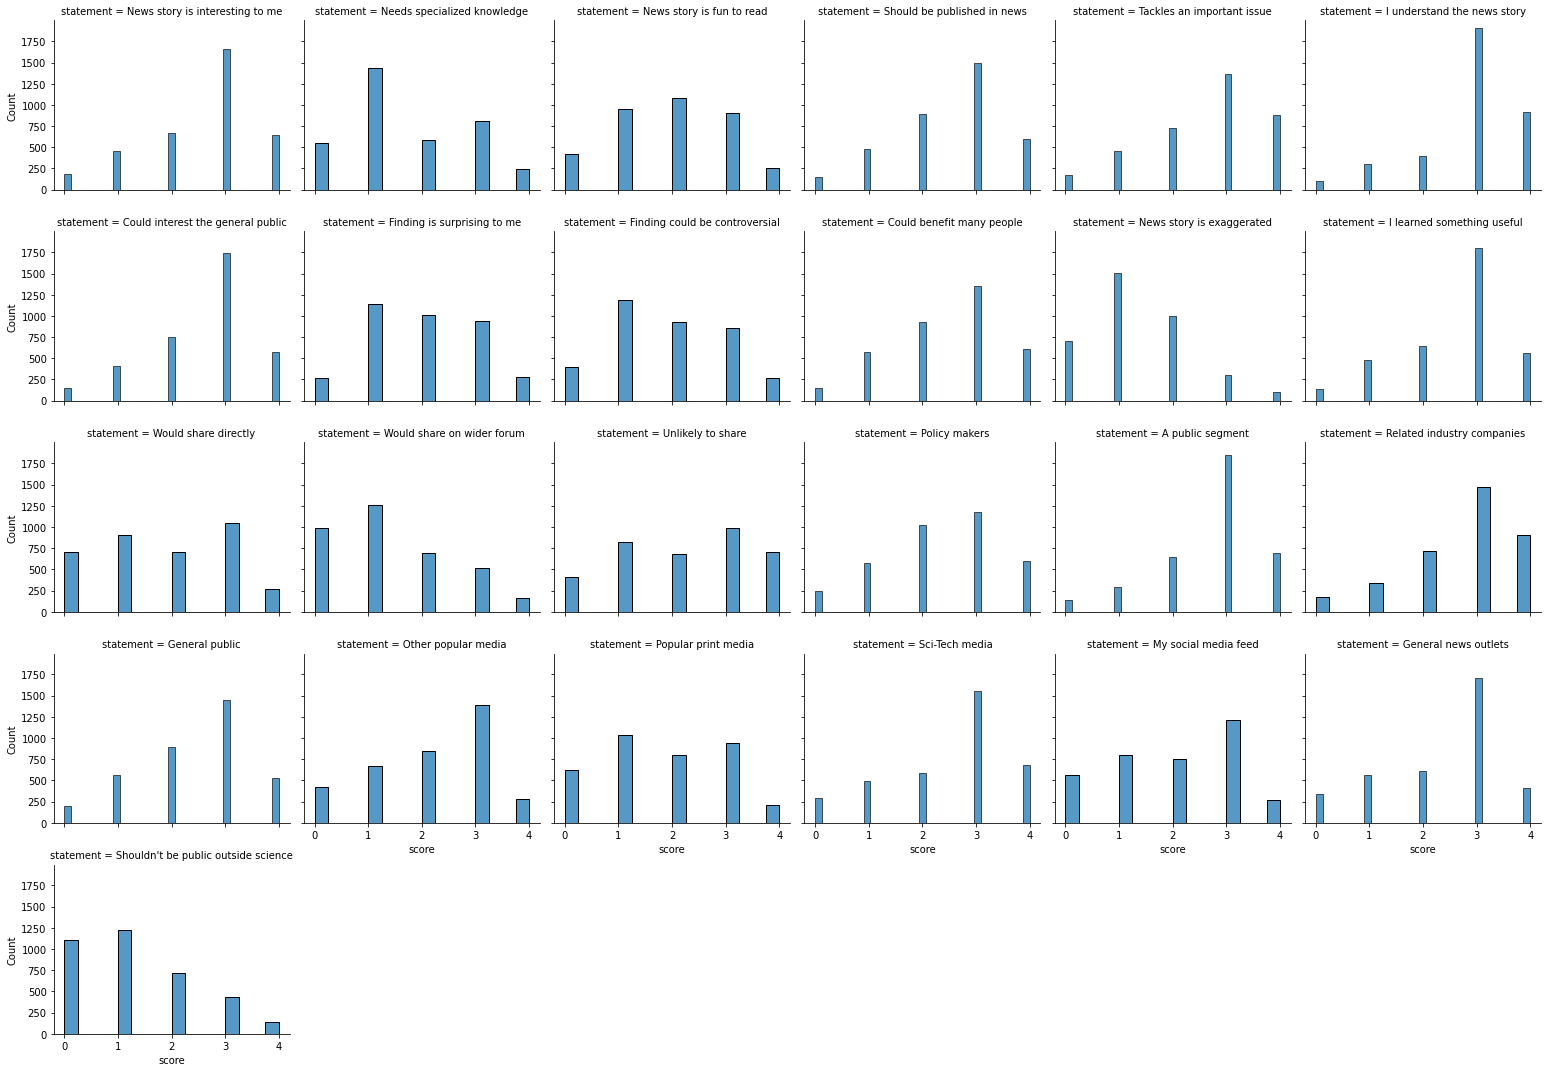

In [586]:
#all_df['statement'] = [s2s[it] for it in all_df['statement']]
g = sns.FacetGrid(all_df, col="statement", col_wrap=6, aspect=1.2)

# Map the histplot to each subplot
g.map(sns.histplot, "score")

# Adjust the spacing between titles
plt.subplots_adjust(top=0.9)
plt.tight_layout()

/opt/anaconda/lib/python3.8/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


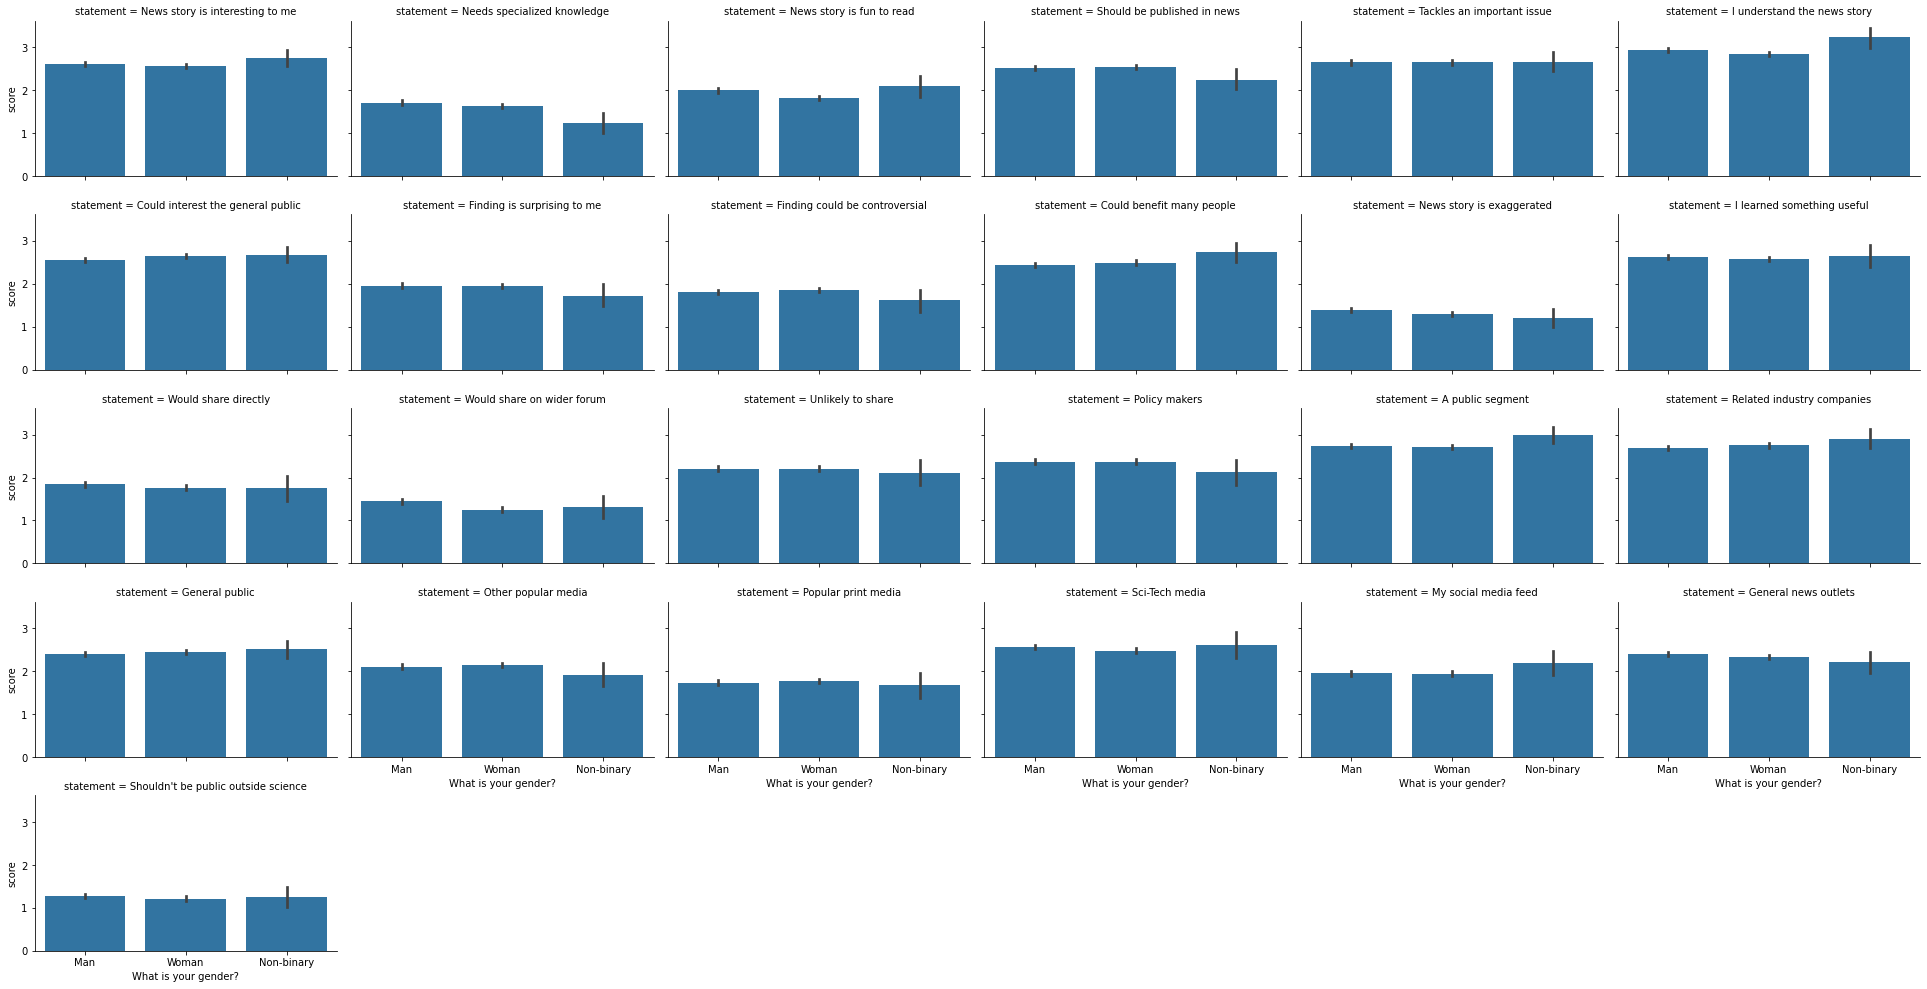

In [528]:
key = 'What is your gender?'
g = sns.FacetGrid(all_df[all_df[key].isin(['Man', 'Woman', 'Non-binary'])], col="statement", col_wrap=6, aspect=1.5)

# Map the histplot to each subplot
g.map(sns.barplot, key,"score")

# Adjust the spacing between titles
plt.subplots_adjust(top=0.9)

In [56]:
stacked_df = pd.DataFrame()
for key in ['nonsci_reader_sore', 'sci_reader_sore']:
    agg_df['score'] = agg_df[key]
    agg_df['score_type'] = key
    stacked_df = pd.concat([stacked_df, agg_df])
stacked_df = stacked_df.reset_index()

In [57]:
stacked_df.statement

0            News story is interesting to me
1            News story is interesting to me
2            News story is interesting to me
3            News story is interesting to me
4            News story is interesting to me
                        ...                 
75295    Shouldn't be public outside science
75296    Shouldn't be public outside science
75297    Shouldn't be public outside science
75298    Shouldn't be public outside science
75299    Shouldn't be public outside science
Name: statement, Length: 75300, dtype: object

<Axes: xlabel='score', ylabel='Density'>

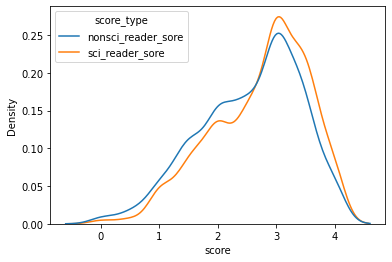

In [62]:
sns.kdeplot(hue='score_type', x='score',data=stacked_df[stacked_df['statement']=='Tackles an important issue'])

## Below are not currently in use

In [46]:
all_df

,Please feel free to leave any comments about our study (optional),What is your education level?,How much do you trust scientists to do their work with the intention of benefiting the public?,What is your gender?,displayed_text,How satisfied do you feel about your experience participating our study?,I will answer all the questions.,Please rate the following statements: The government should actively intervene in the market to ensure equality and consumer protection.,How frequently do you read science news?,How do you feel about your experience participating our study compared with other studies?,...,score,statement,Mention title,category,outlet,coverage_type,big_field,mention_year,doi,cleaned_text
0,None,High school diploma or equivalent,Moderate trust,Man,"<div style=""width: 1000px; height: 600px; over...",None,None,Disagree,Monthly,None,...,3.0,News story is interesting to me,Scientists Restore Some Functions in A Pig’s B...,PressRelease,Environmental News Network,coverage_30_sup,Medicine,2019,10.1038/s41586-019-1099-1,Circulation and cellular activity were restore...
2,None,High school diploma or equivalent,Moderate trust,Man,"<div style=""width: 1000px; height: 600px; over...",None,None,Disagree,Monthly,None,...,3.0,News story is interesting to me,A glimmer of hope for the world's coral reefs:...,PressRelease,Science Daily,all_covered,Science,2018,10.1038/s41558-018-0351-2,The future of the world's coral reefs is uncer...
5,None,High school diploma or equivalent,Moderate trust,Man,"<div style=""width: 1000px; height: 600px; over...",None,None,Disagree,Monthly,None,...,1.0,News story is interesting to me,Key processes of photosynthesis simulated on t...,PressRelease,Nanowerk,pr_sci_covered,Science,2013,10.1126/science.1244843,Key processes of photosynthesis simulated on t...
8,None,High school diploma or equivalent,Moderate trust,Man,"<div style=""width: 1000px; height: 600px; over...",None,None,Disagree,Monthly,None,...,2.0,News story is interesting to me,"Synthetic biology on ordinary paper, results o...",PressRelease,Nanowerk,all_covered,Science,2014,10.1016/j.cell.2014.10.004,"Synthetic biology on ordinary paper, results o..."
9,None,High school diploma or equivalent,Moderate trust,Man,"<div style=""width: 1000px; height: 600px; over...",None,None,Disagree,Monthly,None,...,1.0,News story is interesting to me,Ribena Hair Dye Anyone?,SciTech,Technology Networks,pr_sci_covered,Science,2018,10.1021/acs.jafc.8b01044,Natural dyes extracted from blackcurrant waste...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19577,None,"College or university degree (e.g. BSc, BA)",None,Woman,"<div style=""width: 1000px; height: 600px; over...",None,None,None,None,None,...,2.0,Shouldn't be public outside science,Signaling Pathways Linking Stem Cells an...,SciTech,GEN,pr_sci_covered,Science,2018,10.1126/science.aan4153,Scientists from the University of Pennsylvania...
19578,None,"College or university degree (e.g. BSc, BA)",None,Woman,"<div style=""width: 1000px; height: 600px; over...",None,None,None,None,None,...,2.0,Shouldn't be public outside science,Newly Published Data from National Study Suppo...,General,Benzinga,gen_only_covered,Medicine,2018,10.1016/j.gie.2018.10.049,"Interpace Diagnostics Group, Inc. (NASDAQ:IDXG..."
19579,None,"College or university degree (e.g. BSc, BA)",None,Woman,"<div style=""width: 1000px; height: 600px; over...",None,None,None,None,None,...,1.0,Shouldn't be public outside science,Nano memory cell can mimic the brain?s long-te...,PressRelease,Nanowerk,engineering_sup,Engineering,2015,10.1002/adfm.201501019,Nano memory cell can mimic the brain's long-te...
19581,None,"College or university degree (e.g. BSc, BA)",None,Woman,"<div style=""width: 1000px; height: 600px; over...",None,None,None,None,None,...,1.0,Shouldn't be public outside science,Opinion: China's Role As The World's Developme...,General,WUWM,gen_only_covered,Social Science,2018,10.1016/j.enpol.2018.06.009

In [652]:
s2s.values()

dict_values(['News story is interesting to me', 'Needs specialized knowledge', 'News story is fun to read', 'Should be published in news', 'Tackles an important issue', 'I understand the news story', 'Could interest the general public', 'Finding is surprising to me', 'Finding could be controversial', 'Could benefit many people', 'News story is exaggerated', 'I learned something useful', 'Would share directly', 'Would share on wider forum', 'Unlikely to share', 'Policy makers', 'A public segment', 'Related industry companies', 'General public', 'Other popular media', 'Popular print media', 'Sci-Tech media', 'My social media feed', 'General news outlets', "Shouldn't be public outside science"])

In [657]:
t_df.keys()

Index(['science_news_consumption',
       'Please feel free to leave any comments about our study (optional)',
       'instance_id', 'trust_in_scientist_ability',
       'knowledge_about_scientists', 'displayed_text',
       'Please rate the following statements: Individuals should have the right to define their own gender identity and marry whomever they choose.',
       'I have read and understood the instructions.', 'Asian_details',
       'study_experience_comparison', 'get_news_from_outlets',
       'Please rate the following statements: Drugs, especially softer ones like marijuana, should be decriminalized or legalized.',
       'Please rate the following statements: The government should actively intervene in the market to ensure equality and consumer protection.',
       'topic_of_interests',
       'Please rate the following statements: Wealthy individuals and corporations should pay a higher tax rate to fund public services.',
       'Please rate the following statements: Wom

In [1]:
key = 'Should be published in news'
t_df = all_df[all_df['statement'] == key].rename(columns=question2key)
t_df = t_df[~t_df.score.isna()]
t_df = t_df[~t_df.race.isin(['Prefer not to disclose','Native Hawaiian or Pacific Islander','American India or Alaska Native'])]
t_df = t_df[~t_df.gender.isin(['Prefer not to disclose', 'free_response'])]
t_df = t_df[~t_df.education.isin(['Prefer not to disclose'])]
#t_df['education'] = ['0' if it == 'High school diploma or equivalent' else it for it in t_df['education']]
t_df = t_df.reset_index().drop(columns=['index'])
mod = ols(formula = 'score' + ' ~ gender + age + education + category + big_field + sample + science_news_consumption',
                      data=t_df)
res = mod.fit()
print(res.summary())
res_df =  results_summary_to_dataframe(res)

NameError: name 'all_df' is not defined

In [54]:
key = 'News story is interesting to me'
t_df = all_df[all_df['statement'] == key].rename(columns=question2key)
t_df = t_df[~t_df.score.isna()]
t_df = t_df[~t_df.race.isin(['Prefer not to disclose','Native Hawaiian or Pacific Islander','American India or Alaska Native'])]
t_df = t_df[~t_df.gender.isin(['Prefer not to disclose', 'free_response'])]
t_df = t_df[~t_df.education.isin(['Prefer not to disclose'])]
#t_df['education'] = ['0' if it == 'High school diploma or equivalent' else it for it in t_df['education']]
t_df = t_df.reset_index().drop(columns=['index'])
mod = ols(formula = 'score' + ' ~ gender + age + education + category + big_field + sample',
                      data=t_df)
res = mod.fit()
print(res.summary())
res_df =  results_summary_to_dataframe(res)

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     5.232
Date:                Mon, 13 Nov 2023   Prob (F-statistic):           1.30e-15
Time:                        10:03:25   Log-Likelihood:                -13965.
No. Observations:                9410   AIC:                         2.798e+04
Df Residuals:                    9385   BIC:                         2.816e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [92]:
print(res.summary().as_latex())

\begin{table}
\caption{Mixed Linear Model Regression Results}
\label{}
\begin{center}
\begin{tabular}{llll}
\hline
Model:            & MixedLM & Dependent Variable: & politeness   \\
No. Observations: & 23700   & Method:             & REML         \\
No. Groups:       & 3718    & Scale:              & 0.8860       \\
Min. group size:  & 2       & Log-Likelihood:     & -35558.1555  \\
Max. group size:  & 8       & Converged:          & Yes          \\
Mean group size:  & 6.4     &                     &              \\
\hline
\end{tabular}
\end{center}

\begin{center}
\begin{tabular}{lrrrrrr}
\hline
                                  &  Coef. & Std.Err. &      z & P$> |$z$|$ & [0.025 & 0.975]  \\
\hline
Intercept                         &  3.167 &    0.035 & 89.497 &       0.000 &  3.098 &  3.236  \\
gender[T.Non-binary]              & -0.048 &    0.042 & -1.149 &       0.250 & -0.130 &  0.034  \\
gender[T.Woman]                   & -0.042 &    0.014 & -3.116 &       0.002 & -0.069 & -0.0

/var/folders/cj/_szp19bx18ncbq3vhgh2zj_80000gr/T/ipykernel_11966/2532438192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
/var/folders/cj/_szp19bx18ncbq3vhgh2zj_80000gr/T/ipykernel_11966/3119033402.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(df['term']), fontsize=14)


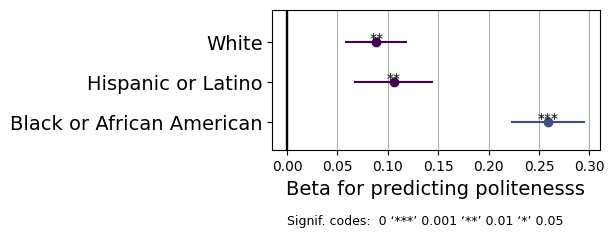

In [59]:
t_df = res_df[res_df['term'].str.contains('race')]
t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
t_df = t_df[~t_df.term.isin(['Prefer not to disclose','Native Hawaiian or Pacific Islander'])]
#t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
plot_reg_results(t_df, xlabel='Beta for predicting politenesss',figsize=(4,2),filename='politeness_race_reg')

/var/folders/cj/_szp19bx18ncbq3vhgh2zj_80000gr/T/ipykernel_11966/465540969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
/var/folders/cj/_szp19bx18ncbq3vhgh2zj_80000gr/T/ipykernel_11966/3119033402.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(df['term']), fontsize=14)


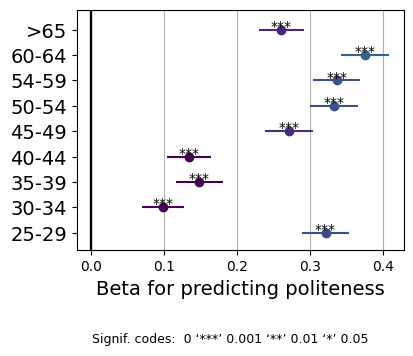

In [ ]:
t_df = res_df[res_df['term'].str.contains('age')]
t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
#t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
plot_reg_results(t_df, xlabel='Beta for predicting politeness',figsize=(4,3),filename='politeness_age_reg')

/var/folders/cj/_szp19bx18ncbq3vhgh2zj_80000gr/T/ipykernel_11966/2024312932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
/var/folders/cj/_szp19bx18ncbq3vhgh2zj_80000gr/T/ipykernel_11966/3119033402.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(df['term']), fontsize=14)


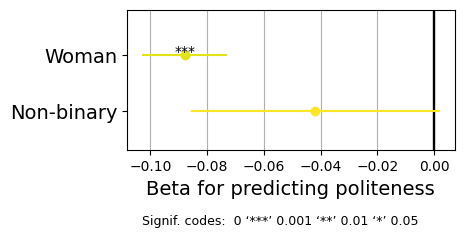

In [ ]:
t_df = res_df[res_df['term'].str.contains('gender')]
t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
t_df = t_df[~t_df.term.isin(['Prefer not to disclose','Native Hawaiian or Pacific Islander'])]
#t_df['term'] = [it.split('.')[-1][:-1] for it in t_df['term']]
plot_reg_results(t_df, xlabel='Beta for predicting politeness',figsize=(4,2),filename='politeness_gender_reg')